In [90]:
import numpy as np
from astropy.io import fits
import cv2
import os
import math
import glob
import re 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [15]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [16]:
def min_max(x, ax, ay):
    min_x = x.min()
    max_x = x.max()
    a = np.zeros((ay, ax))
    b = np.zeros((ay, ax))
    z = np.zeros((ay, ax))
    for i in range(ay):
        for j in range(ax):
            z[i][j] = (x[i][j] - min_x)/(max_x - min_x) * 255
            a[i][j],b[i][j] = math.modf(z[i][j])

    return a,b

In [17]:
def split_images(image_files, batch_size):
    return [image_files[i:i + batch_size] for i in range(0, len(image_files), batch_size)]

In [18]:
def name_decision(image_files):
    name_prefix = []
    dir = image_files[0].split("/scattered")
    di = dir[0].split("preprocess/")
    for i,name in enumerate(image_files):
        parts = name.split(".f")
        part = parts[0].split("correction/")
        p = f"{part[1]}_reg_"
        print(p)
        name_prefix.append(p)
    return name_prefix, di[1]

In [86]:
def aa(image, i):
    global i_start, i_end, j_start, j_end
    i_start = 1
    j_start = 40
    j_end = -10
    g = fits.getdata(image)
    s = g[i_start:, j_start:j_end]
    cv2.imwrite(f"test{i}.tif",s.astype('uint16'))

In [87]:
def image_conv(image):
    global i_start, i_end, j_start, j_end
    i_start = 1
    j_start = 2
    j_end = -1
    g = fits.getdata(image)
    # g[g < 0] = 0
    s = g[i_start:-1, j_start:j_end]
    cv2.imwrite("test.tif",s.astype('uint16'))
    c = cv2.imread("test.tif",-1)

    return c
def make_base_images(image_files):
    images = []
    f = []
    images_uint16 = []
    t = []
    for i,filename in enumerate(image_files):
        images_uint16.append(image_conv(filename))
        f.append(fits.getdata(filename)[i_start:, j_start:j_end])
        hdu = fits.open(filename)[0]
        t.append(hdu.header["EXP_0"])
        # t.append(hdu.header["TEXP"])
        a,b = min_max(f[i], f[i].shape[1], f[i].shape[0])
        images.append(np.uint8(b))
    return images_uint16, t, images

In [39]:
def image_registration(image_files):
    #名前の決定と保存ディレクトリの決定
    name_prefix, target_directory = name_decision(image_files)
    #tifファイルへの変換と積分時間の中主値，元画像の整数部分を持つ画像の作成
    images_uint16 = []
    t = []
    images = []
    images_uint16, t, images = make_base_images(image_files)

    home_dir = os.path.expanduser("~")
    output_directory = os.path.join(home_dir, f"Documents/after_graduate2/output_preprocess/{target_directory}/registration/")
    registered_images = []
    registered_pngs = []
    reference_image = images[1]
    save_dir = f"../output_preprocess/{target_directory}/registration"
    path = Path(save_dir)
    path.mkdir(exist_ok=True)


    # 基準画像から他の画像への変換行列を計算し、変換を適用
    for i,image_file in enumerate(images):
        print(i)
        # 画像の特徴点を検出
        akaze = cv2.AKAZE_create()
        keypoints1, descriptors1 = akaze.detectAndCompute(reference_image, None)
        keypoints2, descriptors2 = akaze.detectAndCompute(image_file, None)
        
        # 特徴点マッチングと変換行列の計算
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors2, descriptors1, k = 2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append([m])
        #適切なキーポイントを選択
        src_pts = np.float32([keypoints2[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints1[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, inliers = cv2.estimateAffine2D(src_pts, dst_pts)
        
        # 変換行列を適用して画像を基準画像の座標系に変換
        # if i == 3:
        #     print(src_pts, dst_pts)
        # print(M.dtype)
        registered_image = cv2.warpAffine(images_uint16[i], M, (reference_image.shape[1], reference_image.shape[0]), flags=cv2.INTER_NEAREST)
        registered_png= cv2.warpAffine(image_file, M, (reference_image.shape[1], reference_image.shape[0]), flags=cv2.INTER_NEAREST)
        registered_image[(registered_image <= 500) | (registered_image >= 4700)] = 0
        registered_images.append(registered_image)
        registered_pngs.append(registered_png)

    for i in range(len(registered_images)):
        output_jpgname = f"{output_directory}{name_prefix[i]}.png"
        output_filename = f"{output_directory}{name_prefix[i]}.fits"
        cv2.imwrite(output_jpgname, registered_pngs[i])
        hdu = fits.PrimaryHDU(registered_images[i])
        hdu.header['EXP_0']=t[i]
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(output_filename, overwrite=True)



In [21]:
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    new_min = 0
    new_max = 255

    normalized_data = ((data - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

    return normalized_data

In [93]:
def make_color_image(registered_images, num, tar_dir):
    registered_image = []
    for i in range(len(registered_images)):
        registered_image.append(normalize(fits.getdata(registered_images[i])))
    col_img = cv2.merge((registered_image[0],registered_image[1],registered_image[2]))
    output_directory = f"../output_preprocess/{tar_dir}/registration/"
    path = Path(output_directory)
    path.mkdir(exist_ok=True)
    output_colpngname = f"{output_directory}{num}.jpg"
    cv2.imwrite(output_colpngname, col_img)

In [96]:
image_lists = ['../output_preprocess/20051011/scattered_correction/cor2_st_2450510529_b.fit', 
               '../output_preprocess/20051011/scattered_correction/cor2_st_2450514369_v.fit',
               '../output_preprocess/20051011/scattered_correction/cor2_st_2450518275_w.fit',
               '../output_preprocess/20051011/scattered_correction/cor2_st_2450529877_p.fit']
i = 3
f = fits.getdata(image_lists[i])
f[f< 0] = 0
a,b = min_max(f, f.shape[1], f.shape[0])
images = np.uint8(b)
print(images)
aa(image_lists[i],i)
cv2.imwrite(f"test{i}.png", images)
registered_image = image_conv(image_lists[i])
hdu = fits.PrimaryHDU(registered_image)
hdulist = fits.HDUList([hdu])
hdulist.writeto(f"test{i}.fit", overwrite=True)


[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 1]]


In [45]:
base_directory = f"../output_preprocess/"
for directory in sorted(os.listdir(base_directory), key = natural_keys):
    if("20051" in directory):
        print(directory)
        image_dir = f"../output_preprocess/{directory}/scattered_correction/"
        image_files = sorted(glob.glob(os.path.join(image_dir, "*.fit")), key = natural_keys)

        batch_size = 4

        image_batches = split_images(image_files, batch_size)
        for i, images in enumerate(image_batches):
            image_registration(images)

20051013
cor1_st_2455782773_b_reg_
cor1_st_2455786613_v_reg_
cor1_st_2455790502_w_reg_
cor1_st_2455794390_p_reg_
0
1
2
3
cor1_st_2456105349_b_reg_
cor1_st_2456109221_v_reg_
cor1_st_2456113110_w_reg_
cor1_st_2456116950_p_reg_
0
1
2
3
cor1_st_2456804222_b_reg_
cor1_st_2456808094_v_reg_
cor1_st_2456811983_w_reg_
cor1_st_2456815840_p_reg_
0
1
2
3
cor1_st_2457157533_b_reg_
cor1_st_2457161422_v_reg_
cor1_st_2457165278_w_reg_
cor1_st_2457169150_p_reg_
0
1
2
3
cor1_st_2457506969_b_reg_
cor1_st_2457510874_v_reg_
cor1_st_2457514731_w_reg_
cor1_st_2457518587_p_reg_
0
1
2
3
cor2_st_2455759994_b_reg_
cor2_st_2455763851_v_reg_
cor2_st_2455767707_w_reg_
cor2_st_2455771580_p_reg_
0
1
2
3
cor2_st_2458520717_b_reg_
cor2_st_2458521713_v_reg_
cor2_st_2458522710_w_reg_
cor2_st_2458523691_p_reg_


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [88]:
target_dir = "20051119"
image_dir = f"../output_preprocess/{target_dir}/scattered_correction/"
image_files = sorted(glob.glob(os.path.join(image_dir, "*.fit")))

batch_size = 4
global i_start, i_end, j_start, j_end
i_start = 1
j_start = 2
j_end = -1
image_batches = split_images(image_files, batch_size)
print(len(image_batches))
for i, file in enumerate(image_batches[2]):
    a = fits.getdata(file)
    fits.writeto(f"{i}.fits", a[i_start:-1, j_start:j_end], overwrite = True)
    if i == 3:
        image_registration(image_batches[2])

3
cor1_st_2572086065_b_reg_
cor1_st_2572727016_v_reg_
cor1_st_2572732931_w_reg_
cor1_st_2572739419_p_reg_
0
1
2
3


In [34]:
target_dir = "20051013"
image_dir = f"../output_preprocess/{target_dir}/scattered_correction/"
image_files = sorted(glob.glob(os.path.join(image_dir, "*.fit")))

batch_size = 4

image_batches = split_images(image_files, batch_size)

print(len(image_batches))
for i in range(len(image_batches)):
    image_registration(image_batches[i])

# image_registration(image_batches[7])

7
cor2_st_2444959649_b_reg_
cor2_st_2444963521_v_reg_
cor2_st_2444967362_w_reg_
cor2_st_2444971267_p_reg_
cor2_st_2444978849_b_reg_
cor2_st_2444982722_v_reg_
cor2_st_2444986562_w_reg_
cor2_st_2444990467_p_reg_


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/imgwarp.cpp:2604: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


['../output_preprocess/20051024/scattered_correction/cor2_st_2486640220_b.fit', '../output_preprocess/20051024/scattered_correction/cor2_st_2486649845_v.fit', '../output_preprocess/20051024/scattered_correction/cor2_st_2486659453_w.fit', '../output_preprocess/20051024/scattered_correction/cor2_st_2486669110_p.fit']
(512, 512)


True

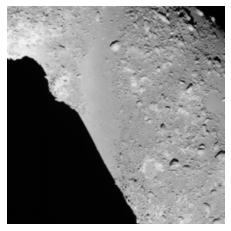

In [30]:
target_dir = "20051024"
image_dir = f"../output_preprocess/{target_dir}/scattered_correction/"
image_files = sorted(glob.glob(os.path.join(image_dir, "*.fit")))

batch_size = 4

image_batches = split_images(image_files, batch_size)

print(image_batches[0])
image = fits.getdata(image_batches[1][0])
print(image.shape)
plt.imshow(image, cmap = "gray")
plt.axis('off')
cv2.imwrite("jjjj.png", normalize(image))

In [94]:
base_directory = f"../output_preprocess/"
for directory in os.listdir(base_directory):
    print(directory)
    image_dir = f"../output_preprocess/{directory}/registration/"
    image_files = sorted(glob.glob(os.path.join(image_dir, "*.fits")))

    batch_size = 4

    image_batches = split_images(image_files, batch_size)
    for i, images in enumerate(image_batches):
        make_color_image(image_batches[i], i, directory)

20050917
20050921
20050919
.DS_Store
20050918
20050929
20051016
20051019
20051119
20050925
20050923
20050924
20051024
20051025
20051014
20051013
20051103
20051104


In [6]:
# FITS画像ファイルのリストを作成
# image_files = ["../../gra/HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2491939184_b.fit",
#                "../../gra/HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2491942076_v.fit",
#                "../../gra/HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2491945018_w.fit",
#                  "../../gra/HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2491947926_p.fit"]  # すべての画像ファイルを含むリスト

# image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2489428266_b.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2489432123_v.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2489436012_w.fit",
#                  "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2489439885_p.fit"]        #test


# image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450856292_b.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450860165_v.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450864005_w.fit",
#                  "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450867894_p.fit"]  #ishiguro2010

# image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450510529_b.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450514369_v.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450518275_w.fit",
#                  "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2450529877_p.fit"]  #ishiguro2010

# image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451086681_b.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451090553_v.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451094410_w.fit",
#                  "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451098282_p.fit"]  #ishiguro2010

# image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451547456_b.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451551346_v.fit",
#                "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451555202_w.fit",
#                  "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051011/st_2451559075_p.fit"]  #ishiguro2010
 
image_files = ["../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490234689_b.fit",
               "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490238562_v.fit",
               "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490242451_w.fit",
               "../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490246307_p.fit"]

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2489428266_b.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2489432123_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2489436012_w.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2489439885_p.fit"]

# image_files = ["../preprocess/test/before_ref/cor1_st_2489428266_b.fit",
#                "../preprocess//test/before_ref/cor1_st_2489432123_v.fit",
#                "../preprocess/test/before_ref/cor1_st_2489436012_w.fit",
#                "../preprocess/test/before_ref/cor1_st_2489439885_p.fit"]

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2385559680_b.fit",
#                "../preprocess//test/before_ref/bef_scacor1_st_2385578902_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2385598109_w.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2385655809_p.fit"]     #ishiguro2014

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2450856292_b.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2450860165_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2450864005_w.fit",
#                  "../preprocess/test/before_ref/bef_scacor1_st_2450867894_p.fit"]  #ishiguro2010

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2450510529_b.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2450514369_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2450518275_w.fit",
#                  "../preprocess/test/before_ref/bef_scacor1_st_2450529877_p.fit"]  #ishiguro2010

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2451086681_b.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2451090553_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2451094410_w.fit",
#                  "../preprocess/test/before_ref/bef_scacor1_st_2451098282_p.fit"]  #ishiguro2010

# image_files = ["../preprocess/test/before_ref/bef_scacor1_st_2451547456_b.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2451551346_v.fit",
#                "../preprocess/test/before_ref/bef_scacor1_st_2451555202_w.fit",
#                  "../preprocess/test/before_ref/bef_scacor1_st_2451559075_p.fit"]

# 出力ディレクトリとファイル名のプレフィックスを指定
home_dir = os.path.expanduser("~")
output_directory = os.path.join(home_dir, "Documents/after_graduate2/output_directory_op/")
file_prefix = 'registered_image_'  # ファイル名のプレフィックスを指定

hdulist = fits.open(image_files[2])  
hdu = hdulist[0]
data = hdu.data
header = hdu.header

name_prefix = []
# for i,name in enumerate(image_files):
#     parts = name.split(".f")
#     part = parts[0].split("/test/")
#     par = part[1].split("_ref/")
#     p = f"{par[1]}_reg_"
#     name_prefix.append(p)

for i,name in enumerate(image_files):
    parts = name.split(".f")
    part = parts[0].split("/data/")
    par = part[1].split("/st")
    p = f"{par[1]}_reg_"
    name_prefix.append(p)
# name = image_files[0]
# parts = name.split(".f")
# part = parts[0].split("/data/")
# par = part[1].split("/st")
# p = f"{par[0]}"
# name_prefix.append(p)

# 最初の画像を基準画像として読み込み
images = []
#少数部分の保存
float_images = []
f = []
images_uint16 = []
t = []
for i,filename in enumerate(image_files):
    print(filename)
    images_uint16.append(image_conv(filename))
    f.append(fits.getdata(filename))
    print(f[i].shape)
    hdu = fits.open(filename)[0]
    t.append(hdu.header["EXP_0"])
    # t.append(hdu.header["TEXP"])
    a,b = min_max(f[i], f[i].shape[1], f[i].shape[0])
    if i == 2:
      reference_image = np.uint8(b)
    images.append(np.uint8(b))
    float_images.append(a)
  
print(t)


../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490234689_b.fit
(256, 256)
../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490238562_v.fit
(256, 256)
../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490242451_w.fit
(256, 256)
../HAY_A_AMICA_3_HAYAMICA_V1_0/data/20051025/st_2490246307_p.fit
(256, 256)
[0.131, 0.087, 0.0655, 0.174]


In [128]:
output_directory = os.path.join(home_dir, "Documents/after_graduate2/output_perspective/")
registered_images = []
registered_png = []


# 基準画像から他の画像への変換行列を計算し、変換を適用
for i,image_file in enumerate(images):
    
    # 画像の特徴点を検出
    akaze = cv2.AKAZE_create()
    keypoints1, descriptors1 = akaze.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(image_file, None)
    
    # 特徴点マッチングと変換行列の計算
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors2, descriptors1, k = 2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
    
    #適切なキーポイントを選択
    src_pts = np.float32([keypoints2[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints1[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, inliers = cv2.estimateAffine2D(src_pts, dst_pts)
    
    # 変換行列を適用して画像を基準画像の座標系に変換
    registered_image = cv2.warpAffine(images_uint16[i], M, (image_file.shape[1], image_file.shape[0]), flags=cv2.INTER_NEAREST)
    registered_png= cv2.warpAffine(image_file, M, (image_file.shape[1], image_file.shape[0]), flags=cv2.INTER_NEAREST)
    registered_image[(registered_image <= 1000) | (registered_image >= 4700)] = 0
    registered_images.append(registered_image)

for i in range(len(registered_images)):
    output_jpgname = f"{output_directory}{name_prefix[i]}.png"
    output_filename = f"{output_directory}{name_prefix[i]}.fits"
    cv2.imwrite(output_jpgname, registered_png)
    hdu = fits.PrimaryHDU(registered_images[i])
    hdu.header['EXP_0']=t[i]
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(output_filename, overwrite=True)



error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


In [142]:
col_img = []
col_img = cv2.merge((registered_images[0],registered_images[1],registered_images[2]))
name = image_files[0]
parts = name.split(".f")
part = parts[0].split("/data/")
par = part[1].split("/st")
col_name = "_color"
p = f"{par[0]}{col_name}"
name_prefix.append(p)
output_coljpgname = f"{output_directory}{name_prefix[4]}_2.jpg"
cv2.imwrite(output_coljpgname, col_img)

True

In [159]:
affine_matrix = M

# アフィン変換行列から回転の角度、平行移動、拡大倍率を取得
angle = np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0])
translation_x = affine_matrix[0, 2]
translation_y = affine_matrix[1, 2]
scale_x = affine_matrix[0, 0]
scale_y = affine_matrix[1, 1]

# 角度を度数法に変換
angle_degrees = np.degrees(angle)

cx = translation_x / np.cos(angle)
cy = translation_y / np.sin(angle)

# 結果
print("回転角度（度数法）:", angle_degrees)
print("X方向の平行移動:", translation_x)
print("Y方向の平行移動:", translation_y)
print("X方向の拡大倍率:", scale_x)
print("Y方向の拡大倍率:", scale_y)
print("回転中心のX座標:", cx)
print("回転中心のY座標:", cy)

回転角度（度数法）: 0.10421876184939545
X方向の平行移動: -1.9579941654023187
Y方向の平行移動: 1.778319978824197
X方向の拡大倍率: 0.9942943214010063
Y方向の拡大倍率: 1.0024314931226048
回転中心のX座標: -1.9579974045335997
回転中心のY座標: 977.6578016120237


In [127]:
hdu = fits.open("../output_preprocess/20051022/registration/cor2_st_2481913332_v_reg_.fits")[0]
header = hdu.header
data = hdu.data
ys = header["NAXIS1"]
xs = header["NAXIS2"]
max_data = 0
for i in range(xs):
    for j in range(ys):
        if(data[i][j]>=max_data):
            max_data = data[i][j]
            max_i = i
            max_j = j

print(max_j, max_i)

9 145
